<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# ARIMA Code-Along

_Authors: Joseph Nelson (DC)_

---

> **Note:** This code-along lesson is intended to come after the slideshow presentation and be guided in detail by the instructor.

### Learning Objectives
- Practice using Statsmodels' time series tools on bus ridership data.
- Plot the decomposition of the time series.
- Conduct a Dickey-Fuller test for stationarity and plot the results.
- Perform first and second order differencing, as well as seasonal differencing on data.
- Plot ACF and PACF with European retail data.
- Examine the use of SARIMAX state-space modeling for advanced time series forecasting.

### Lesson Guide
- [Statsmodels' Time Series Tools](#statsmodels-timeseries-tools)
- [Bus Ridership Data](#bus-ridership-data)
	- [Clean the Data](#clean-the-data)
	- [Create a Date Index for the Data](#create-a-date-index-for-the-data)
- [Plot the Riders Across Months](#plot-the-riders-across-months)
- [Decompose the Time Series and Plot](#decompose-the-timeseries-and-plot)
- [Dickey-Fuller Test of Stationarity](#dickey-fuller-test-of-stationarity)
	- [Perform a Test on the First-Differenced Time Series](#perform-test-on-the-first-differenced-timeseries)
	- [Perform a Test on *Seasonal*-Differenced Time Series](#perform-test-on-seasonal-differenced-timeseries)
	- [Perform a Test on the First Seasonal-Differenced Time Series](#perform-a-test-on-the-first-seasonal-differenced-timeseries)
- [Load the European Retail Data](#load-the-european-retail-data)
- [Create Autocorrelation and Partial Autocorrelation Plots](#create-autocorrelation-and-partial-autocorrelation-plots)
	- [Take a Second-Order Difference of the Retail Time Series](#take-a-second-order-difference-of-the-retail-timeseries)
- [Seasonal ARIMA With Additional Predictors (SARIMAX)](#seasonal-arima-with-additional-predictors-sarimax)
	- [Forecast Using the SARIMAX Model](#forecast-using-the-sarimax-model)
- [Additional Resources](#additional-resources)

In [2]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
import seaborn as sns

<a id="statsmodels-timeseries-tools"></a>
## Statsmodels' Time Series Tools
---

Statsmodels (the dev version), offers a wide variety of reliable time series analysis tools. We will start off by loading the autocorrelation and partial autocorrelation functions, as well as a function for decomposing time series.

In [3]:
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.seasonal import seasonal_decompose

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


<a id="bus-ridership-data"></a>
## Bus Ridership Data
---

We are going to play around with some Portland, Oregon, bus data. Load in the bus data below and check it out.

<a id="clean-the-data"></a>
### Clean the Data

In [4]:
# Data: https://datamarket.com/data/set/22w6/portland-oregon-average-monthly-bus-ridership-100-january-1973-through-june-1982-n114#!ds=22w6&display=line
bus = pd.read_csv('./datasets/portland-oregon-average-monthly-.csv', index_col=0)
bus.index.name=None
bus.reset_index(inplace=True)
bus.head()

,index,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
0,1960-01,648
1,1960-02,646
2,1960-03,639
3,1960-04,654
4,1960-05,630


In [5]:
bus.tail()

,index,"Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114"
111,1969-04,1432
112,1969-05,1394
113,1969-06,1327
114,NaN,NaN
115,Portland Oregon average monthly bus ridership ...,n=114


There are a couple of bad rows. Get rid of them.

In [6]:
bus2 = bus.iloc[:-2,:]

In [7]:
bus2.columns

Index([u'index', u'Portland Oregon average monthly bus ridership (/100) January 1973 through June 1982, n=114'], dtype='object')

Make the `riders` column an integer.

In [8]:
bus2.columns = ['period','riders']
bus2['riders'] = bus2['riders'].astype('int')
bus2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 2 columns):
period    114 non-null object
riders    114 non-null int32
dtypes: int32(1), object(1)
memory usage: 1.4+ KB


C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


<a id="create-a-date-index-for-the-data"></a>
### Create a Date Index for the Data

We are going to create an artificial date index using the `relativedelta()` function, as exemplified below. We will simply start at `1973-01-01` and iterate up a month at a time.

In [9]:
# A:

In [10]:
dt_ind = []
for i in range(len(bus2)):
    dt_ind.append(pd.to_datetime('1973-01-01')+relativedelta(months=+i))

In [11]:
bus2['dt_ind'] = pd.DataFrame(dt_ind)

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [12]:
bus2.set_index('dt_ind', drop=True, inplace=True)

<a id="plot-the-riders-across-months"></a>
## Plot the Riders Across Months
---

We can look at the raw ridership data first.

In [13]:
bus2.drop('period', axis=1, inplace=True)

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


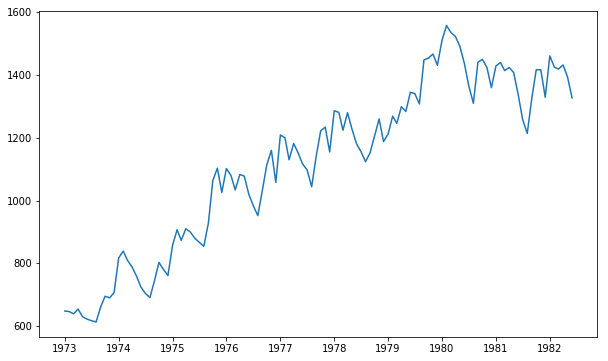

In [14]:
plt.figure(figsize=(10,6))
plt.plot(bus2)

In [15]:
# A:

<a id="decompose-the-timeseries-and-plot"></a>
## Decompose the Time Series and Plot
---

Using the `seasonal_decompose()` function, we can break the time series into its constituent parts.

Use the function on the `riders` data with a frequency of 12, then plot the data.

> **Hint:** The decomposition object from `seasonal_decompose()` has a `.plot()` function, like with Pandas DataFrames.

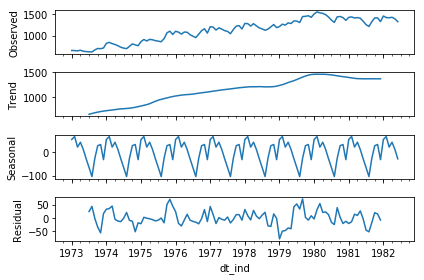

In [16]:
result = seasonal_decompose(bus2)
result.plot();

In [17]:
# A:

**Plot just the seasonal component.**

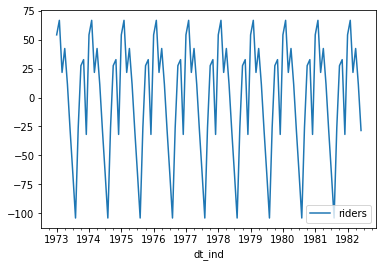

In [18]:
result.seasonal.plot()

In [19]:
# A:

<a id="dickey-fuller-test-of-stationarity"></a>
## Dickey-Fuller Test of Stationarity
---

[We can perform an (augmented) Dickey-Fuller test of stationarity](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test) to evaluate whether or not the time series is stationary.


In [20]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)
    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean')
    plt.show(block=False)
    
    # Perform Augmented Dickey-Fuller test:
    print 'Results of Augmented Dickey-Fuller test:'
    dftest = adfuller(timeseries)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


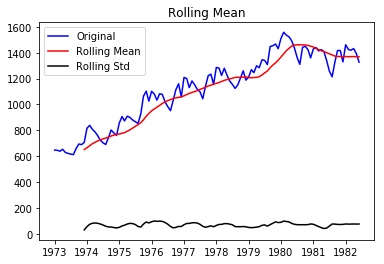

Results of Augmented Dickey-Fuller test:
Test Statistic                  -1.536597
p-value                          0.515336
#Lags Used                      12.000000
Number of Observations Used    101.000000
Critical Value (5%)             -2.890611
Critical Value (1%)             -3.496818
Critical Value (10%)            -2.582277
dtype: float64


In [21]:
test_stationarity(bus2['riders'])

In [22]:
# Perform test.


<a id="perform-test-on-the-first-differenced-timeseries"></a>
### Perform a Test on the First-Differenced Time Series

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\pandas\core\series.py:2993: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)
C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).m

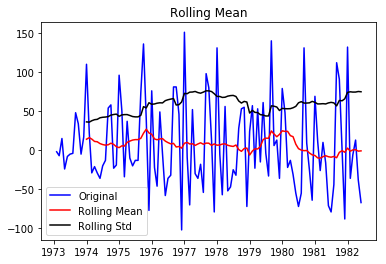

Results of Augmented Dickey-Fuller test:
Test Statistic                  -1.938696
p-value                          0.314082
#Lags Used                      11.000000
Number of Observations Used    101.000000
Critical Value (5%)             -2.890611
Critical Value (1%)             -3.496818
Critical Value (10%)            -2.582277
dtype: float64


In [23]:
bus2['riders_diff'] = bus2['riders'].diff()
bus2['riders_diff'].dropna(inplace=True)
test_stationarity(bus2['riders_diff'])

In [24]:
# A:

<a id="perform-test-on-seasonal-differenced-timeseries"></a>
### Perform a Test on *Seasonal*-Differenced Time Series

Where the season will be a year's difference (12 months).

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
  after removing the cwd from sys.path.
C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()
  """


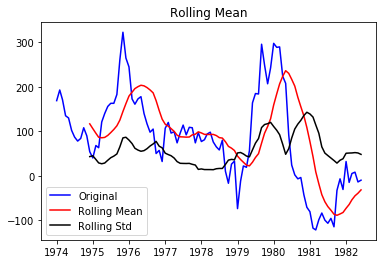

Results of Augmented Dickey-Fuller test:
Test Statistic                 -2.469741
p-value                         0.123011
#Lags Used                      3.000000
Number of Observations Used    98.000000
Critical Value (5%)            -2.891516
Critical Value (1%)            -3.498910
Critical Value (10%)           -2.582760
dtype: float64


In [25]:
bus2['riders_diff'] = bus2['riders'].diff(periods=12) #annual seasonality
bus2['riders_diff'].dropna(inplace=True)
test_stationarity(bus2['riders_diff'])

In [26]:
# A:

<a id="perform-a-test-on-the-first-seasonal-differenced-timeseries"></a>
### Perform a Test on the First Seasonal-Differenced Time Series

At this point, we can see that we have a significant result!

C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Samson\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: pd.rolling_mean is deprecated fo

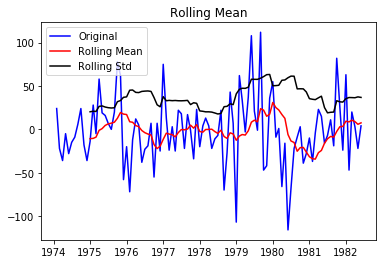

Results of Augmented Dickey-Fuller test:
Test Statistic                -9.258520e+00
p-value                        1.427874e-15
#Lags Used                     0.000000e+00
Number of Observations Used    1.000000e+02
Critical Value (5%)           -2.890906e+00
Critical Value (1%)           -3.497501e+00
Critical Value (10%)          -2.582435e+00
dtype: float64


In [27]:
bus2['riders_diff'] = bus2['riders'].diff(periods=1) #first diff
bus2['riders_diff'].dropna(inplace=True)
bus2['riders_diff2'] = bus2['riders_diff'].diff(periods=12) #annual seasonality
bus2['riders_diff2'].dropna(inplace=True)
test_stationarity(bus2['riders_diff2'])

In [28]:
# A:

<a id="load-the-european-retail-data"></a>
## Load the European Retail Data
---

Make the index the year and create an initial plot of the data.

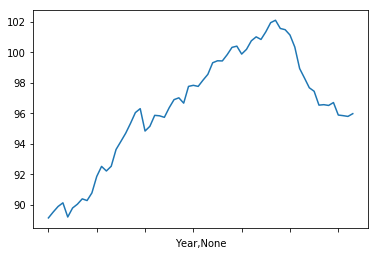

In [29]:
df = pd.read_csv('./datasets/euretail.csv')
df = df.set_index(['Year'])
df.head()
df.stack().plot()

<a id="create-autocorrelation-and-partial-autocorrelation-plots"></a>
## Create Autocorrelation and Partial Autocorrelation Plots 
---

Create a first-differenced time series of the retail data, then use `plot_acf` and `plot_pacf`.

In [30]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

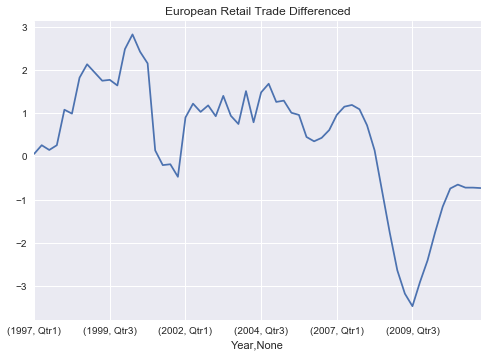

In [30]:
# A:

<a id="take-a-second-order-difference-of-the-retail-timeseries"></a>
### Take a Second-Order Difference of the Retail Time Series

Plot the ACF and PACF again with the second-order differenced series.

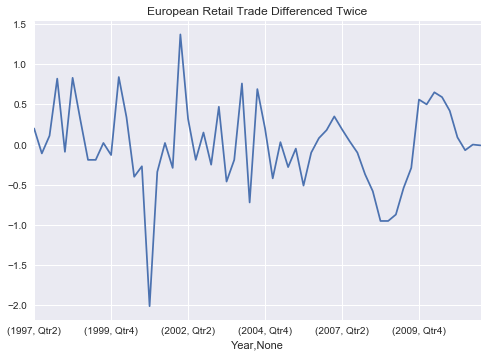

In [36]:
# A:

<a id="seasonal-arima-with-additional-predictors-sarimax"></a>
## Seasonal ARIMA With Additional Predictors (SARIMAX)
---

The [SARIMAX model](http://www.statsmodels.org/dev/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html) is an advanced state-space model that allows us to build a seasonal ARIMA and also take into account the effects of other predictors.

The granular details of SARIMAX are beyond the scope of this walk-through, but we can build a model and use it to forecast as an example of Statsmodels' powerful time series analysis capabilities.

In [40]:
import statsmodels.api as sm
data = df.stack().values
model = sm.tsa.statespace.SARIMAX(data, order=(0,1,1), 
                                  seasonal_order=(0,1,1,4))
results = model.fit()
print results.summary()

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 -34.680
Date:                           Mon, 03 Apr 2017   AIC                             75.360
Time:                                   19:27:27   BIC                             81.593
Sample:                                        0   HQIC                            77.793
                                            - 64                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2901      0.155      1.868      0.062      -0.014       0.594
ma.S.L4       -0.6909      0.132     -5.240

**Plot the residuals of the SARIMAX model.**

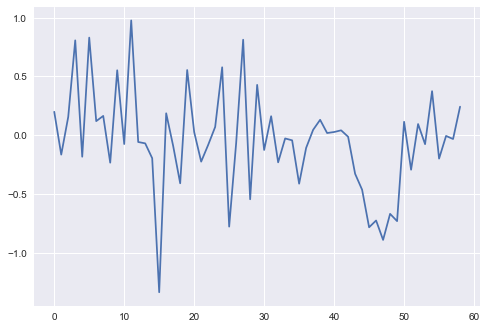

In [41]:
# A:

**Plot the ACF and PACF of the residuals.**

What should we expect from the ACF and PACF of our residuals if the model is good?

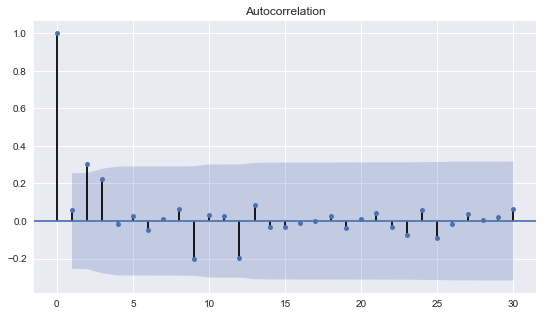

In [42]:
# A:

**Increase the order of the SARIMAX model.**

How do the results change?

In [44]:
# A:

                                 Statespace Model Results                                
Dep. Variable:                                 y   No. Observations:                   64
Model:             SARIMAX(0, 1, 2)x(0, 1, 1, 4)   Log Likelihood                 -32.809
Date:                           Mon, 03 Apr 2017   AIC                             73.618
Time:                                   19:30:15   BIC                             81.928
Sample:                                        0   HQIC                            76.862
                                            - 64                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.2307      0.157      1.471      0.141      -0.077       0.538
ma.L2          0.2498      0.115      2.171

<a id="forecast-using-the-sarimax-model"></a>
### Forecast Using the SARIMAX Model

Statsmodels result objects from SARIMAX have a `.forecast()` function that can use the state-space model to predict out to future time points.

Forecast 12 additional time points and plot them.

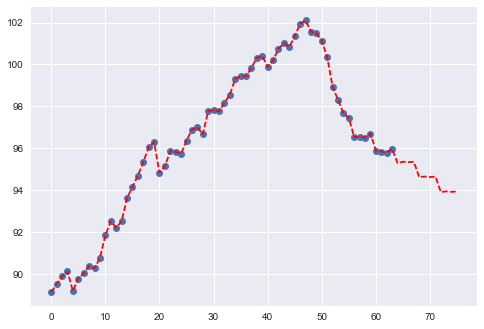

In [47]:
# Forecasting:
res = model.fit()
preds = res.forecast(12)
fcast = np.concatenate((data, preds), axis=0)

plt.figure();
plt.plot(data, 'o' , fcast, 'r--');

<a id='additional-resources'></a>
## Additional Resources
---

+ A Soft Introduction to [Akaike Information Criteria](https://coolstatsblog.com/2013/08/14/using-aic-to-test-arima-models-2/)
+ A [Video Introduction](https://www.youtube.com/watch?v=YkD7ydzp9_E) to AIC
+ [Wikipedia's Entry on AIC](https://en.wikipedia.org/wiki/Akaike_information_criterion)
+ A Seasonal ARIMA [Code-Along](http://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html) From Statsmodels
+ An excellent [Blog Code-Along](http://www.seanabu.com/2016/03/22/time-series-seasonal-ARIMA-model-in-python/) to Seasonal ARIMA + [iPython Notebook](https://github.com/seanabu/seanabu.github.io/blob/master/Seasonal_ARIMA_model_Portland_transit.ipynb)
+ Duke's Breakdown of [ACF and PACF](http://people.duke.edu/~rnau/411arim3.htm)
+ Duke's Breakdown of Available [Stationarity Transformations](http://people.duke.edu/~rnau/whatuse.htm)
+ A 35-Minute [Video Econometric](https://www.youtube.com/watch?v=Y2khrpVo6qI) Breakdown of ARIMA
+ [Wikipedia's Entry on Dickey-Fuller](https://en.wikipedia.org/wiki/Dickey%E2%80%93Fuller_test)
+ Stats Exchange's Breakdown of [Augmented Dickey-Fuller](http://stats.stackexchange.com/questions/44647/which-dickey-fuller-test-should-i-apply-to-a-time-series-with-an-underlying-mode)
+ Compliments of Jonathan: A Walk-Through of Selecting PDQ from [Duke](http://people.duke.edu/~rnau/411arim.htm)
+ Compliments of Jonathan, Pt. 2: A Big Data Analytics With ARIMA [Case Study](http://sda-pakdd2014.weebly.com/uploads/2/4/0/8/24088081/7w12.pdf)
+ Bonus: Check Out [Granger Causality Tests](https://en.wikipedia.org/wiki/Granger_causality)
